In [1]:
from glob import iglob
from functools import reduce, partial

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, DataFrame
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType, size, col, lit, explode
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, ArrayType
import matplotlib.pyplot as plt
from numpy import linspace, histogram, histogram2d, array
from numba import jit
import dask.array as da

Connect to Spark master

In [2]:
conf = (SparkConf()
        .setAppName("test pipico")
        .setMaster("spark://carbon.uedalab.local:7077")
        .set("spark.jars.packages", "org.diana-hep:spark-root_2.11:0.1.15")
        .set("spark.cores.max", 4))
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

Read root files

In [3]:
globbed = iglob("/helium/analysis/saito/SortEvent_aq002_t100_b.root")
roots = (sqlContext
         .read
         .format("org.dianahep.sparkroot")
         .load(fn) for fn in globbed)
df = reduce(DataFrame.unionAll, roots)
df.printSchema()

root
 |-- SortedEvent: struct (nullable = true)
 |    |-- fEventID: long (nullable = true)
 |    |-- fDetektors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- fDetektors_fHits: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- fPDNbr: integer (nullable = true)
 |    |    |    |    |    |-- fHitNbr: integer (nullable = true)
 |    |    |    |    |    |-- fU1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fU2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fMcpNbr: integer (nullable = true)
 |    |    |    |    |    |-- fX_mm: double (nullable = true)
 |    |    |    |    |    |-- fY_mm: double (

Restruct

In [4]:
HitType = StructType([
    StructField('x', DoubleType(), nullable=False),
    StructField('y', DoubleType(), nullable=False),
    StructField('t', DoubleType(), nullable=False),
    StructField('flag', IntegerType(), nullable=False)])


@udf(ArrayType(HitType))
def combine_hits(xarr, yarr, tarr, flagarr):
    return [{'x': x,
             'y': y,
             't': t,
             'flag': f
            } for x, y, t, f in zip(xarr, yarr, tarr, flagarr)]


chits = col('SortedEvent.fDetektors').getItem(0).getField('fDetektors_fHits')
restructed = (df
              .withColumn('hits', combine_hits(chits.getField('fX_mm'),
                                               chits.getField('fY_mm'),
                                               chits.getField('fTime'),
                                               chits.getField('fRekmeth')))
              .select(col('SortedEvent.fEventID').alias("tag"), 'hits'))
restructed.printSchema()

root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- t: double (nullable = false)
 |    |    |-- flag: integer (nullable = false)



# Covariance map

Load data to Memory

In [20]:
loaded = (restructed
          .filter(size('hits')!=0)
          .select('hits.t')
          .limit(1000000000)
          .rdd
          .flatMap(list)
          .collect())

Estimate covariance

In [126]:
%%time
bin_config = {'bins': 500, 'range': (2000, 4000)}

arrs = [da.from_array(array(arr), chunks=-1) for arr in loaded[:100000]]
hists = [da.histogram(arr, **bin_config)[0] for arr in arrs]
stacked = da.stack(hists, axis=-1).rechunk((None, 10000))
cov = da.cov(stacked)
img = cov.compute()

CPU times: user 2min 57s, sys: 23.3 s, total: 3min 20s
Wall time: 2min 53s


Plot

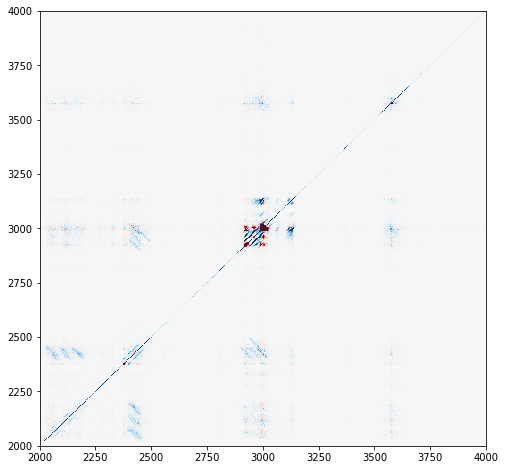

In [127]:
edges = linspace(*bin_config['range'], bin_config['bins']+1)

plt.figure(figsize=(8, 8))
plt.pcolormesh(edges, edges, img, cmap='RdBu')
plt.clim(-0.001, 0.001)
# plt.colorbar()
plt.show()

In [128]:
sc.stop()